## **Schapen detecteren**

### Inladen van de libraries

In [2]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### Inladen van data

(3609, 600, 600, 3)

(174, 600, 600, 3)

(350, 600, 600, 3)

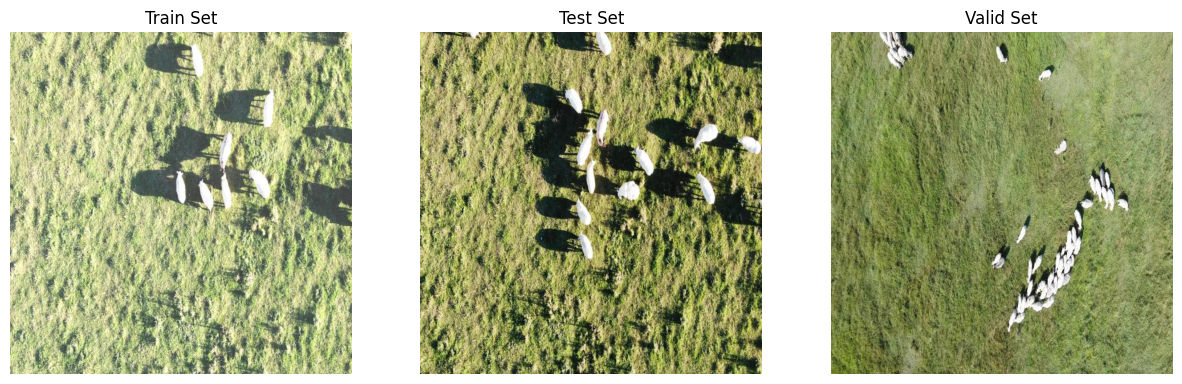

In [5]:
def laad_afbeeldingen(map_pad):
    afbeeldingen = []
    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            afbeeldingen.append(np.array(afbeelding))

    return np.array(afbeeldingen)

def toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen, valid_afbeeldingen):
    train_afbeelding = train_afbeeldingen[np.random.randint(len(train_afbeeldingen))]
    test_afbeelding = test_afbeeldingen[np.random.randint(len(test_afbeeldingen))]
    valid_afbeelding = valid_afbeeldingen[np.random.randint(len(valid_afbeeldingen))]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(train_afbeelding)
    axs[0].set_title("Train Set")
    axs[0].axis('off')
    axs[1].imshow(test_afbeelding)
    axs[1].set_title("Test Set")
    axs[1].axis('off')
    axs[2].imshow(valid_afbeelding)
    axs[2].set_title("Valid Set")
    axs[2].axis('off')
    plt.show()

train_map_pad = 'train'
train_afbeeldingen = laad_afbeeldingen(train_map_pad)

test_map_pad = 'test'
test_afbeeldingen = laad_afbeeldingen(test_map_pad)

valid_map_pad = 'valid'
valid_afbeeldingen = laad_afbeeldingen(valid_map_pad)

display(train_afbeeldingen.shape, test_afbeeldingen.shape, valid_afbeeldingen.shape)

toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen, valid_afbeeldingen)

In [30]:
# Annotaties inlezen
train_annotaties_path = 'train_annotations.csv'
train_annotaties_df = pd.read_csv(train_annotaties_path)

merge_df = train_annotaties_df.groupby('filename').size().reset_index(name='aantal_schapen')
merge_df.head(5)

,filename,aantal_schapen
0,DJI_0004_0254_jpg.rf.0333171523950809f232bef7d...,19
1,DJI_0004_0254_jpg.rf.513d3cfa85ecfd7fac2f4bc2f...,17
2,DJI_0004_0254_jpg.rf.e5144c31935a35755134e5dfb...,20
3,DJI_0004_0255_jpg.rf.0cd3e42a2edd84243f435ecec...,19
4,DJI_0004_0255_jpg.rf.1e51f56a40b71cd3dd740f118...,22


In [31]:
# Functie om afbeeldingen te laden op basis van bestandspaden
def load_images_from_file_paths(file_paths):
    images = []
    for file_path in file_paths:
        try:
            image = Image.open(file_path)
            images.append(image)
        except Exception as e:
            print(f"Fout bij het openen van afbeelding {file_path}: {e}")
    return images

### DataFrames maken

In [32]:
# Groepen op bestandsnaam en aantal schapen tellen
aantal_schapen_per_afbeelding = train_annotaties_df.groupby('filename').size().reset_index(name='aantal_schapen')

train_files, test_valid_files = train_test_split(aantal_schapen_per_afbeelding['filename'], test_size=0.2, random_state=42)
test_files, valid_files = train_test_split(test_valid_files, test_size=0.5, random_state=42)

# Dataframes voor de train, test en valid sets
train_df = aantal_schapen_per_afbeelding[aantal_schapen_per_afbeelding['filename'].isin(train_files)]
test_df = pd.DataFrame({'filename': test_files})
valid_df = pd.DataFrame({'filename': valid_files})

train_folder_files = [os.path.join(train_map_pad, filename) for filename in os.listdir(train_map_pad) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_folder_files = [os.path.join(test_map_pad, filename) for filename in os.listdir(test_map_pad) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]
valid_folder_files = [os.path.join(valid_map_pad, filename) for filename in os.listdir(valid_map_pad) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Maak dataframes met de werkelijke bestandsnamen
train_df = pd.DataFrame({'filename': train_folder_files})
test_df = pd.DataFrame({'filename': test_folder_files})
valid_df = pd.DataFrame({'filename': valid_folder_files})

# Laad train-, test- en validatieafbeeldingen
train_images = load_images_from_file_paths(train_df['filename'].values)
test_images = load_images_from_file_paths(test_df['filename'].values)
valid_images = load_images_from_file_paths(valid_df['filename'].values)

# Sluit de geopende afbeeldingen om te voorkomen dat er te veel bestanden open blijven
for image in train_images + test_images + valid_images:
    image.close()

# Print de lengtes van de sets
print("Train set lengte:", len(train_df))
print("Test set lengte:", len(test_df))
print("Valid set lengte:", len(valid_df))

Train set lengte: 3609
Test set lengte: 174
Valid set lengte: 350


### **Data preprocessing**

In [33]:
train_df

,filename
0,train/DJI_0040_MOV-155_jpg.rf.92c77235165acc3a...
1,train/DJI_0040_MOV-94_jpg.rf.775b4f3284c408457...
2,train/img_063_jpg.rf.d21a533b99b88f3542aae6350...
3,train/DJI_0039_MOV-181_jpg.rf.2813636344ceb345...
4,train/DJI_0039_MOV-132_jpg.rf.15b6eb8d48b12a31...
...,...
3604,train/DJI_0043_MOV-240_jpg.rf.b500a49dd9550028...
3605,train/DJI_0040_MOV-125_jpg.rf.fb00a71b8df9f15b...
3606,train/DJI_0039_MOV-190_jpg.rf.f68395b846bc558d...
3607,train/DJI_0043_MOV-126_jpg.rf.e538f65c02d02a64...


In [34]:
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.basename(x))
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.basename(x))
valid_df['filename'] = valid_df['filename'].apply(lambda x: os.path.basename(x))

In [35]:
merge_df['filename'] = merge_df['filename'].apply(lambda x: os.path.normpath(x))
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.normpath(x))

# Merge de dataframes op 'filename'
train_df = pd.merge(train_df, merge_df, on='filename', how='left')
train_df

,filename,aantal_schapen
0,DJI_0040_MOV-155_jpg.rf.92c77235165acc3afda743...,89.0
1,DJI_0040_MOV-94_jpg.rf.775b4f3284c40845700dcc2...,95.0
2,img_063_jpg.rf.d21a533b99b88f3542aae63506a0a88...,5.0
3,DJI_0039_MOV-181_jpg.rf.2813636344ceb345431f9b...,42.0
4,DJI_0039_MOV-132_jpg.rf.15b6eb8d48b12a3199cfe6...,52.0
...,...,...
3604,DJI_0043_MOV-240_jpg.rf.b500a49dd955002877b63d...,34.0
3605,DJI_0040_MOV-125_jpg.rf.fb00a71b8df9f15b04934d...,96.0
3606,DJI_0039_MOV-190_jpg.rf.f68395b846bc558dcab349...,49.0
3607,DJI_0043_MOV-126_jpg.rf.e538f65c02d02a6417d23e...,23.0


In [10]:
display(train_df.head(5))
display(test_df.head(5))
display(valid_df.head(5))

,filename,aantal_schapen
0,DJI_0040_MOV-155_jpg.rf.92c77235165acc3afda743...,89.0
1,DJI_0040_MOV-94_jpg.rf.775b4f3284c40845700dcc2...,95.0
2,img_063_jpg.rf.d21a533b99b88f3542aae63506a0a88...,5.0
3,DJI_0039_MOV-181_jpg.rf.2813636344ceb345431f9b...,42.0
4,DJI_0039_MOV-132_jpg.rf.15b6eb8d48b12a3199cfe6...,52.0


,filename
0,DJI_0043_MOV-202_jpg.rf.1cfaf478eb6208da81f1fb...
1,DJI_0043_MOV-233_jpg.rf.13fffc795428529df3e452...
2,DJI_0040_MOV-69_jpg.rf.3cac881015eed2ac76de36f...
3,DJI_0040_MOV-82_jpg.rf.144da1b47fbc4e2b9c9ec87...
4,img_23598_jpg.rf.e51f00b1d13dd201787e233c1ab7c...


,filename
0,DJI_0039_MOV-193_jpg.rf.a1abcfe7d94fe5ff574c74...
1,img_325_jpg.rf.9e21284ae6b206c2b530a7090599ae3...
2,DJI_0004_0287_jpg.rf.c4f3ea1b811cf20aff494d9bc...
3,DJI_0040_MOV-238_jpg.rf.dc88f6d1c2d1880346a55e...
4,DJI_0043_MOV-55_jpg.rf.0c4ab4768a438e2babb775e...


## EDA Afbeeldingen

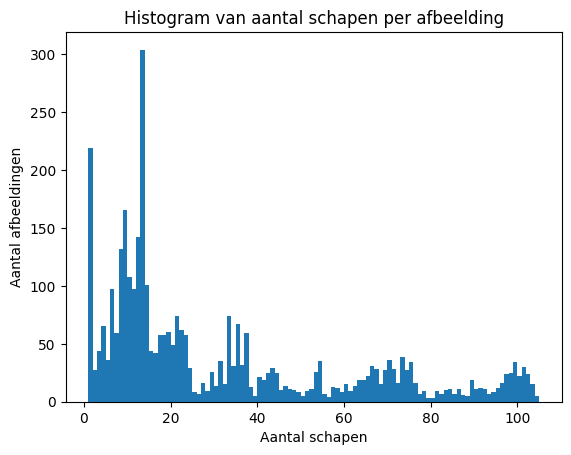

count    3602.000000
mean       31.521932
std        29.066676
min         1.000000
25%        10.000000
50%        19.000000
75%        48.000000
max       105.000000
Name: aantal_schapen, dtype: float64
Modus: 0    13.0
Name: aantal_schapen, dtype: float64


In [11]:
min_aantal_schapen = train_df['aantal_schapen'].min()
max_aantal_schapen = train_df['aantal_schapen'].max()

plt.hist(train_df['aantal_schapen'], bins=range(int(min_aantal_schapen), int(max_aantal_schapen)+1))
plt.title('Histogram van aantal schapen per afbeelding')
plt.xlabel('Aantal schapen')
plt.ylabel('Aantal afbeeldingen')
plt.show()

print(train_df["aantal_schapen"].describe())

print("Modus:", train_df["aantal_schapen"].mode())

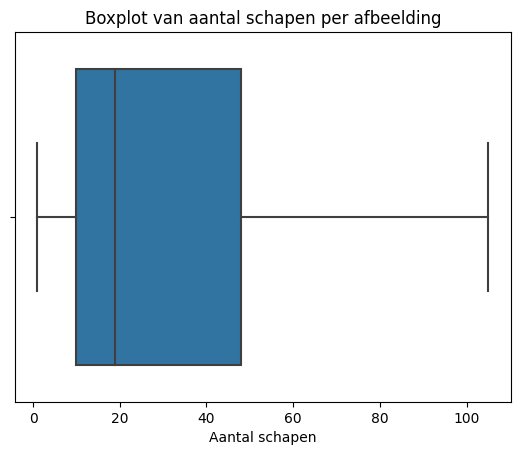

In [12]:
sns.boxplot(x=train_df['aantal_schapen'])
plt.title('Boxplot van aantal schapen per afbeelding')
plt.xlabel('Aantal schapen')
plt.show()

In [19]:
train_df

,filename,aantal_schapen
0,DJI_0040_MOV-155_jpg.rf.92c77235165acc3afda743...,89.0
1,DJI_0040_MOV-94_jpg.rf.775b4f3284c40845700dcc2...,95.0
2,img_063_jpg.rf.d21a533b99b88f3542aae63506a0a88...,5.0
3,DJI_0039_MOV-181_jpg.rf.2813636344ceb345431f9b...,42.0
4,DJI_0039_MOV-132_jpg.rf.15b6eb8d48b12a3199cfe6...,52.0
...,...,...
3604,DJI_0043_MOV-240_jpg.rf.b500a49dd955002877b63d...,34.0
3605,DJI_0040_MOV-125_jpg.rf.fb00a71b8df9f15b04934d...,96.0
3606,DJI_0039_MOV-190_jpg.rf.f68395b846bc558dcab349...,49.0
3607,DJI_0043_MOV-126_jpg.rf.e538f65c02d02a6417d23e...,23.0


### Model

Het gebruik van de lineaire activatiefunctie in de laatste  neuron is geschikt voor regressieproblemen, waarbij we een continue uitvoer willen voorspellen in plaats van een classificatie. In het geval van het tellen van schapen op afbeeldingen, willen we een getal voorspellen dat het aantal schapen op de afbeelding vertegenwoordigt, wat een continue variabele is.

**Mean Squared Error:**
 
 MSE kwadrateert het verschil tussen de voorspelde waarden en de werkelijke waarden en neemt het gemiddelde over alle voorbeelden. Door het kwadrateren van het verschil worden grote fouten zwaarder gewogen dan kleine fouten, wat nuttig is omdat we willen dat ons model zich meer bewust is van grotere afwijkingen. Voor het tellen van schapen willen we de afwijking tussen het voorspelde aantal schapen en het werkelijke aantal schapen minimaliseren, dus MSE is een wordt daarom onze keus.

**Adam Optimizer:**

De reden voor Adam is omdat Adam een zeer populaire techniek en aansluit bij ons regressieprobleem
